In [1]:
#Importamos las bibliotecas 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

In [2]:
#Cargamos el archivo a utilizar 
data = pd.read_csv("Desktop/Facultad/Datos/fiuba-trocafone-tp1-final-set/events.csv", low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null object
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                    

Pasamos las fechas a formate Datetime para poder trabajar mejor con estas

In [4]:
import calendar

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['anio'] = data['timestamp'].dt.year
data['mes'] = data['timestamp'].dt.month
data['mes_nombre'] = data['mes'].apply(lambda x: calendar.month_abbr[x])
data['dia'] = data['timestamp'].dt.day
data['hora'] = data['timestamp'].dt.hour
data['date'] = data['timestamp'].dt.date
data['dia del anio'] = data['timestamp'].dt.dayofyear

In [19]:
data.head(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,screen_resolution,operating_system_version,browser_version,anio,mes,mes_nombre,dia,hora,date,dia del anio
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018,5,May,31,23,2018-05-31,151
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,360x640,Android 6,Chrome Mobile 39,2018,5,May,31,23,2018-05-31,151
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,2018,5,May,31,23,2018-05-31,151
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,2018,5,May,31,23,2018-05-31,151
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,2018,5,May,29,13,2018-05-29,149


Dado que en el set de datos hay informacion del lugar geografico desde el cual se originan los eventos se  analiza esta informacion.

In [8]:
#Se ve cuantas ciudades distintas hay en los datos
len(data.city.dropna().unique())

1939

In [21]:
#Se calcula la cantidad de NaNs para determinar si los datos tienen sentido
cities = data.city.dropna().unique()
cant_nans = len(data) - data['city'].count()
print("cantidad nans: " + str(cant_nans))
print("porcentaje nans: " + str(cant_nans/len(data)))

cantidad nans: 923910
porcentaje nans: 0.9135973135249306


A pesar de que haya mucha cantidad de Nans en los datos, esto no indica datos erroneos. Los NaN se deben a que no todos los eventos guardan la misma informacion. La informacion de la ciudad y pais solo se ve para el evento de 'visited site', y por esto el resto de los eventos no la contienen. Como se ve a continuacion, si se filtra por el evento en cuestion se ve que no hay valores nulos para las columnas 'city', 'region' y 'country'.

In [5]:
data[ data['event'] == 'visited site' ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87378 entries, 1 to 1011284
Data columns (total 23 columns):
timestamp                   87378 non-null object
event                       87378 non-null object
person                      87378 non-null object
url                         0 non-null object
sku                         0 non-null object
model                       0 non-null object
condition                   0 non-null object
storage                     0 non-null object
color                       0 non-null object
skus                        0 non-null object
search_term                 0 non-null object
staticpage                  0 non-null object
campaign_source             0 non-null object
search_engine               0 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                      87378 non-null object
country                     87378

Se busca en que paises se genera mas actividad.

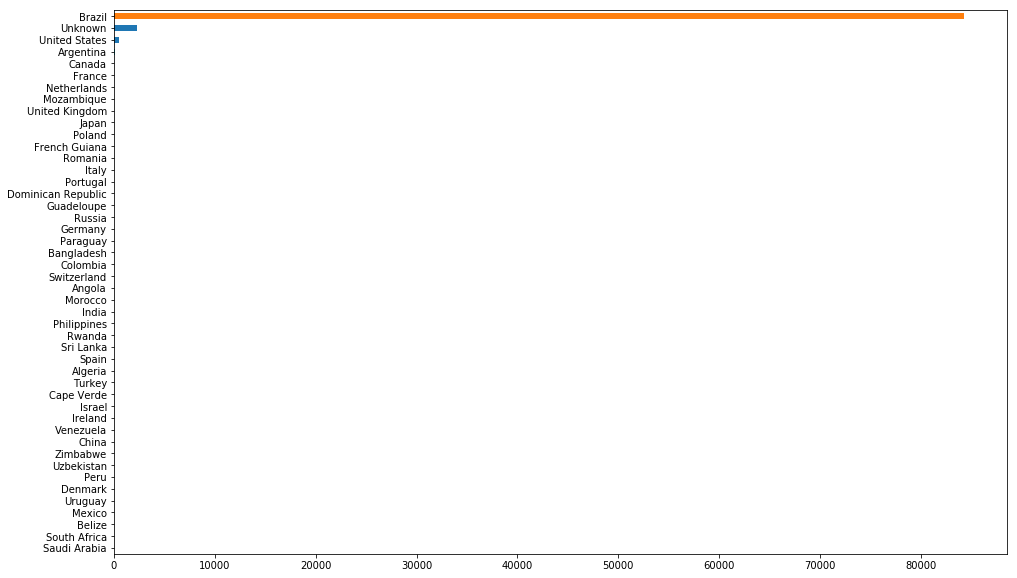

In [23]:
data.country.value_counts(ascending=True).plot(kind='barh', figsize=(16,10))

Como se ve en el grafico Brasil es el pais desde el cual se producen mas ingresos al sitio. Por lo cual decimos analizar los datos segun su horario. 

In [6]:
data.country.value_counts(normalize = True).head()

Brazil           0.964865
Unknown          0.026471
United States    0.005322
Argentina        0.001076
Canada           0.000401
Name: country, dtype: float64

Como se puede ver el 96% de las entradas son desde Brasil, se considera que el timestamp está en zona horaria BRT/ART, por lo cual se manejan los horarios como están, sin verificar la zona horaria del evento . Los valores que presenten un dato erroneo en este caso son despreciables dado que representan un porcentaje bajo de los datos.

Hay una gran cantidad de datos con Country 'unknown', seria interesante analizar si estos se corresponden con city 'unknown' o si hay algun valor del cual se pueda inferir el pais de origen del evento.

In [9]:
data.city.value_counts(normalize=True).head()

Unknown           0.181041
São Paulo         0.134027
Rio de Janeiro    0.040491
Belo Horizonte    0.029390
Salvador          0.026483
Name: city, dtype: float64

In [26]:
country_with_city_unknown = data.loc[data.city == 'Unknown']['country']
print("Cantidad de citys unknown: " + str(country_with_city_unknown.size))
print(country_with_city_unknown.unique())

Cantidad de citys unknown: 15819
['Brazil' 'Unknown' 'Netherlands' 'Argentina' 'France' 'Russia' 'Paraguay'
 'Mozambique' 'United States' 'Canada' 'Philippines' 'Israel'
 'United Kingdom' 'Angola' 'Italy' 'Uzbekistan' 'Belize' 'Colombia'
 'French Guiana' 'Algeria' 'Bangladesh' 'Ireland' 'Zimbabwe' 'Germany'
 'Rwanda' 'Saudi Arabia' 'Cape Verde' 'Denmark' 'Peru' 'Guadeloupe'
 'Morocco' 'Spain']


In [27]:
city_with_country_unknown = data.loc[data.country == 'Unknown']['city']
print("Cantidad de countrys unknown: " + str(city_with_country_unknown.size))
print(city_with_country_unknown.unique())

Cantidad de countrys unknown: 2313
['Unknown']


Se puede ver que los paises 'unknown' se corresponden con city 'unknown'.

In [28]:
del(country_with_city_unknown)
del(city_with_country_unknown)

Mapas
Se buscan las coordenadas de las ciudades para poder graficarlas en un mapa y ver visualmente dónde están los clientes. Se podria dibujar círculos con radio en funcion de la cantidad de compras del lugar, para tener una idea de la importancia de cada lugar para el estudio de mercado.

El df que se lee a continuacion tiene las coordenadas de las ciudades que aparecen en el set de datos. Leer directamente el nuevo dataset con la info guardada y seguir a partir de ahi. Para ver el procesamiento detalladamente, ver notebook correspondiente.

In [10]:
cities_with_coordinates = pd.read_csv('/home/miki_mustard/Datosnot/7506_OrganizacionDeDatos_TP1/data/cities_w_coords_with_completed_nans.csv', index_col=False)

In [11]:
# create cities df
cities_df = pd.DataFrame(cities, columns=['city'])

NameError: name 'cities' is not defined

In [31]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="oiudsf")

In [32]:
from geopy.exc import GeocoderTimedOut
import time

def get_coords(index, x):
    if index % 50 == 0:
        time.sleep(60)
    res = geolocator.geocode(x)
    try:
        return [res.latitude, res.longitude]
    except GeocoderTimedOut:
        return get_coords(x)
    except:
        return [None, None]

In [33]:
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [34]:
cities_df.shape

(1939, 1)

In [12]:
cities_with_coordinates = pd.read_csv('/home/miki_mustard/Datosnot/7506_OrganizacionDeDatos_TP1/data/cities_w_coords_with_completed_nans.csv', index_col=False)

In [13]:
import folium

In [14]:
from folium.plugins import MarkerCluster

avg_lat = cities_with_coordinates['city_lat'].mean()
avg_long = cities_with_coordinates['city_long'].mean()

m = folium.Map(location=[0, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(m)

for lat, lon, city in zip(cities_with_coordinates.city_lat, cities_with_coordinates.city_long, cities_with_coordinates.city):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

m

Como se dijo anteriormente hay informacion que se muestra solo en determinados eventos y no se repite en otros ingresos del mismo usuario. A continuacion se analiza este tema para poder determinar el estado de los datos.

In [ ]:
data.info()

Con lo que obtenido mediante el uso de info() podemos ver que hay algunas columnas que no tienen ningún NAN, estas son:

timestamp
event
person
Tiene sentido que ninguna tenga NAN, ya que en todos los casos corresponde tener esa información.

Ahora, veamos las columnas que tienen alguna densidad de NAN. En principio puede haber NANs porque esa información no corresponde, podemos pensar que el tipo de evento es el que define qué valores corresponden y cuales no. Recordemos los tipos de eventos que teníamos:

In [ ]:
data['event'].value_counts()

Por ejemplo, vemos que tenemos 50957 eventos que corresponden al search engine hit y viendo devuelta lo que obtuvimos con info() también podemos apreciar que hay en la columna de searchengine la misma cantidad de no NANs. Esto se corresponde con lo que habíamos pensado de que a determinados eventos le corresponden determinada información, y por eso en este caso en todas las demás entradas habría NANs, ya que realmente no corresponde.

Estudiemos más a fondo esto. Primero veamos correspondencias entre event y la información en ciertas columnas.

Correspondencia event-informacion

In [ ]:
# Saco las columnas que no me interesan.
filtered = data.drop(['timestamp','person'], axis='columns')

In [ ]:
def columnas_sin_nans_para_event(dataframe, event):
    return dataframe.loc[dataframe.event == event].iloc[0].dropna().index

In [ ]:
# Vemos las columnas que tienen información (ningún NAN) para cada tipo de evento

for event in data.event.unique():
    print(event + ': ' + str(list(columnas_sin_nans_para_event(filtered, event).drop('event'))) + '\n')

Se puede ver como para cada evento tenemos cierta información que tiene sentido tener y cierta que no. De ahí varios NANs que nos aparecen en algunas columnas.

Pero ahora veamos si todos los NANs en las columnas son porque no corresponde tener esa info para el evento o si hay alguna clase de "fuga" de NANs donde sí corresponde tener la información.

In [ ]:
del(filtered)

# Analizamos la relacion general entre los eventos posibles. 

In [19]:
cantidad_eventos = data['event'].value_counts(ascending=True)

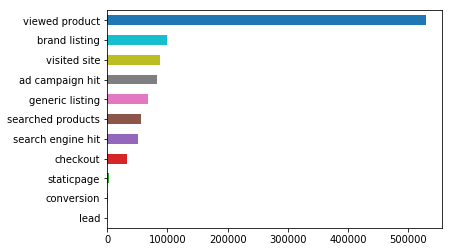

In [20]:
cantidad_eventos.plot(kind='barh')

Se puede ver como el evento viewed product es el mas frecuente, siendo este el evento que representa cuando un usuario ingresa a una pagina de producto. 
Tiene sentido que del evento Lead haya muy poca cantidad dado que representa cuando un usuario ingresa su mail para ser notificado en caso de renovar stock de cierto producto.  
Un evento de particular interes es el de Conversion, dado que indica que se efectuo una compra. En el grafico se puede ver que hay muy pocas conversiones. El evento checkout tambien es importante dado que indica que el usuario selecciono un dispositivo para comprar. 
Se puede graficar la evolucion de los eventos a traves del tiempo.

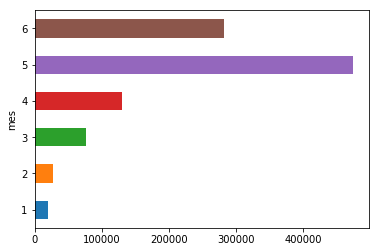

In [23]:
data.groupby('mes').count()['person'].plot(kind='barh')

Hay significativamente mas datos del mes 5. Si los datos son representativos, se podria concluir que hubo mucho mas trafico durante el quinto mes (casi el doble que durante el sexto, que ademas tiene aproximadamente el doble que el cuarto, que es el que mas tiene entre los primeros cuatro.
Surge asi el interrogante: que es lo que hizo que este mes haya tenido mas trafico?


In [25]:
# Se obtiene el día de la semana, se cuenta y se vuelca en un gráfico
days = {6: "Domingo",0: "Lunes",1:"Martes",2: "Miércoles",3: "Jueves",4: "Viernes",5: "Sábado"}

# Se guardan dias de la semana en el orden deseado
sorter = ["Domingo", "Sábado", "Viernes", "Jueves", "Miércoles", "Martes", "Lunes"]
sorterIndex = dict(zip(sorter,range(len(sorter))))

# se crea columna con info del dia de la semana respetando el nombre
data["dia_semana"] = data["timestamp"].dt.dayofweek
data["dia_semana"] = data["dia_semana"].apply(lambda x: days[x])

Text(0,0.5,'Cantidad de eventos')

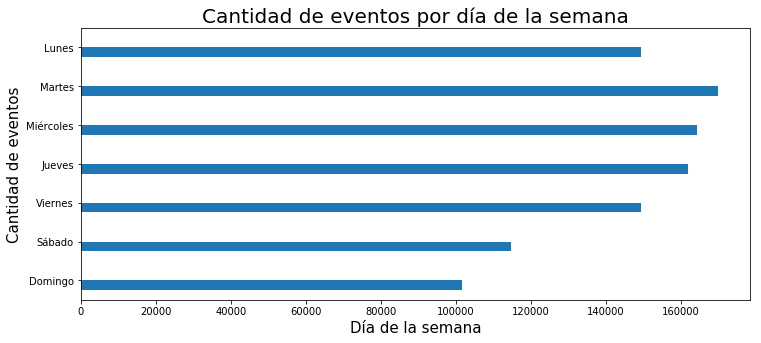

In [26]:
# Se crea df con cantidad de eventos agrupados por dia de la semana
dfEventosAgrupado = data[['event','dia_semana']].groupby("dia_semana").count()
dfEventosAgrupado["dia"] = dfEventosAgrupado.index

# ordenamiento coherente para evitar el default (alfabetico)
dfEventosAgrupado["dia"] = dfEventosAgrupado["dia"].map(sorterIndex)

grafico = dfEventosAgrupado.sort_values("dia").plot(kind = "barh", figsize=(12,5))
grafico.legend_.remove()
grafico.set_title("Cantidad de eventos por día de la semana", fontsize=20)
grafico.set_xlabel("Día de la semana", fontsize=15)
grafico.set_ylabel("Cantidad de eventos", fontsize=15)

Se puede observar que hay menos trafico los fines de semana. Fuera de eso, los niveles se mantienen similares. Se puede suponer que esto se debe a que los fines de semana los usuarios ocupan mas tiempo en actividades sociales y que durante la semana navegan en este tipo de sitios despues del trabajo (o durante? Seguro que no!).

Text(0,0.5,'Cantidad de eventos')

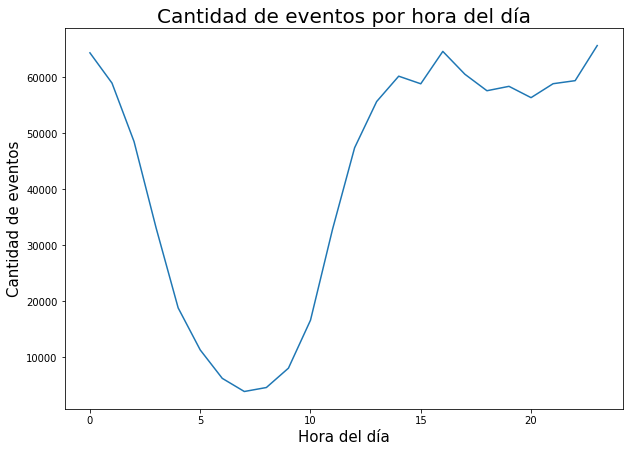

In [40]:
# Se obtiene la hora, se cuenta y se vuelca en un gráfico
grafico = data["timestamp"].dt.hour.value_counts().sort_index().plot(figsize=(10,7))
grafico.set_title("Cantidad de eventos por hora del día", fontsize=20)
grafico.set_xlabel("Hora del día", fontsize = 15)
grafico.set_ylabel("Cantidad de eventos", fontsize = 15)

Como era de esperar, durante la noche se registra una baja en la actividad del sitio.

In [41]:
eventos_en_t  =  pd.DataFrame()
eventos_en_t['date'] = data['timestamp'].dt.date
eventos_en_t['checkout'] = data['event']
eventos_en_t['conversion'] = eventos_en_t['checkout'].str.contains('conversion')
eventos_en_t['ad campaign hit'] = eventos_en_t['checkout'].str.contains('ad campaign hit')
eventos_en_t['viewed product'] = eventos_en_t['checkout'].str.contains('viewed product')
eventos_en_t['visited site'] = eventos_en_t['checkout'].str.contains('visited site')

eventos_en_t['checkout'] = eventos_en_t['checkout'].str.contains('checkout')
grouped = eventos_en_t.groupby('date').sum()

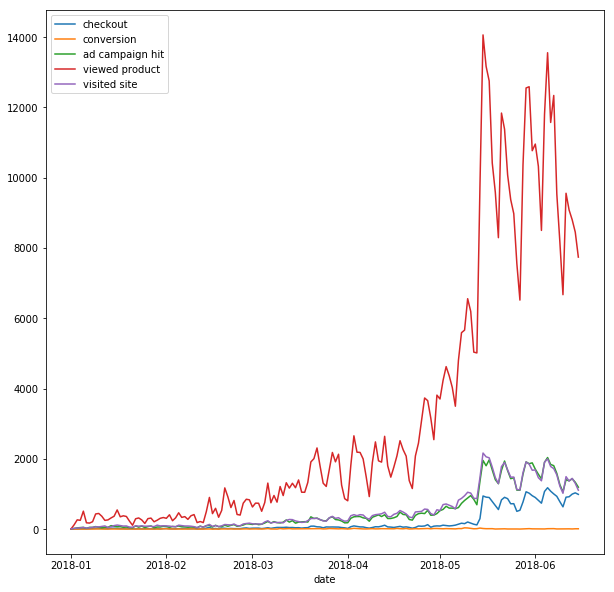

In [42]:
ax = grouped.plot(figsize=(10,10))

Se puede ver como el evento mas predominate es el de 'viewed product'. Analizamos el resto de los eventos sin tenerlo en cuenta.

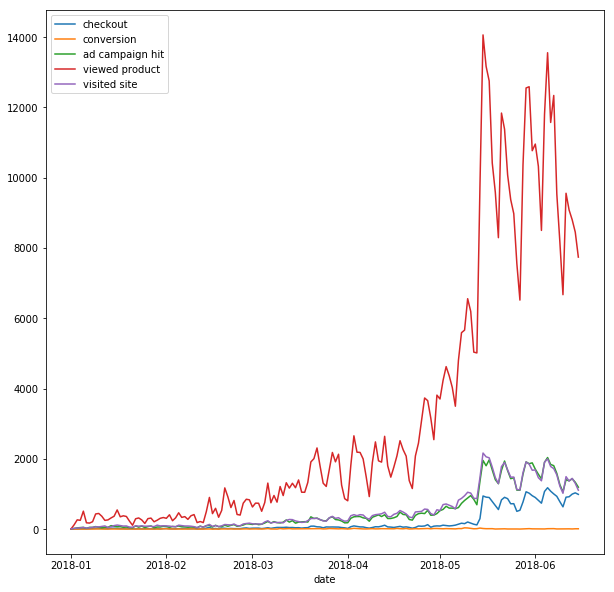

In [43]:
ax = grouped.plot(figsize=(10,10))

Los eventos 'visited site' y 'ad campaign hit' se distribuyen a lo largo del tiempo de forma muy similar.  Mientras que 'checkout' es menos frecuente, y aun menos 'conversion'.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e4193a470>,
      dtype=object)

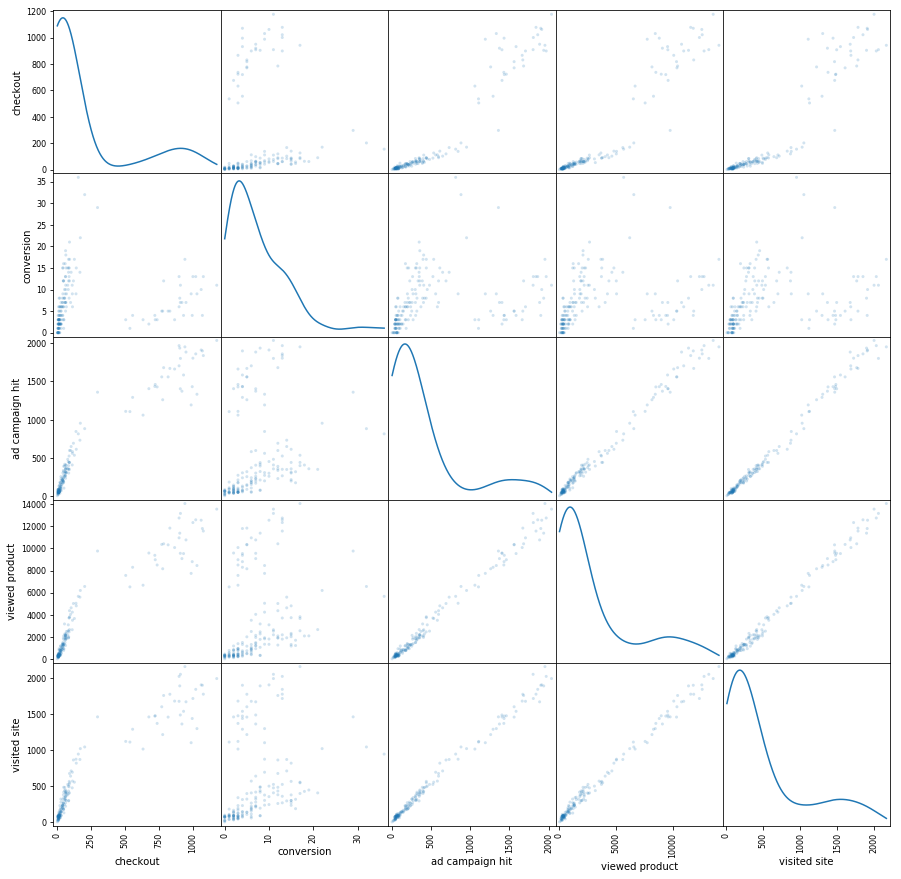

In [44]:
#Si analizamos los mismos datos con un PairGrid
from  pandas.plotting  import scatter_matrix
#En general por fecha
scatter_matrix(grouped, alpha=0.2, figsize=(15, 15), diagonal='kde')

Se obtiene la misma relacion "lineal" entre los eventos 'ad campaign hit' y 'visited site', mientras que entre 'visited site' y 'checkouts' es mas frecuente el primero. Es de especial importancia la relacion entre 'choeckout' y 'conversion'. En este grafico se puede observar como los 'chekout' son mas frecuentes. esto se puede deber a que un usuario busca certo dispositivo y luego no efectua la compra, asi generando uno o mas eventos de 'checkout' y no un evento 'conversion'.

## Analisis del evento 'conversion'

In [57]:
eventos_conversion = data.loc[data.event == 'conversion']
eventos_conversion.shape

(1172, 31)

Cantidad de conversiones durante el año

In [62]:
conversion_per_date = eventos_conversion.timestamp.dt.date.value_counts()

In [67]:
#g = plt.hist(x = conversion_per_date.index, weights = conversion_per_date.values)
#me tira error

Cantidad de conversiones por mes

In [48]:
conversion_per_month = eventos_conversion.mes.value_counts()
conversion_per_month

5    351
4    316
3    265
6    103
2     74
1     63
Name: mes, dtype: int64

Text(0,0.5,'Mes')

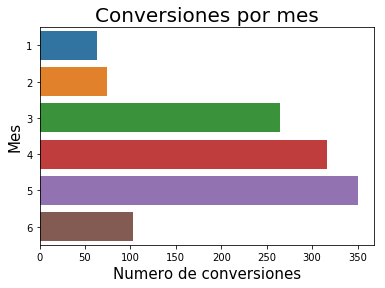

In [49]:
g  =  sns.barplot(x=conversion_per_month.values, y=conversion_per_month.index, orient='h')
g.set_title("Conversiones por mes", fontsize=20)
g.set_xlabel("Numero de conversiones", fontsize=15)
g.set_ylabel("Mes", fontsize=15)

Con lo anterior vemos que durante los meses 3-5 son los que se tuvo más eventos de conversion.

In [50]:
del(conversion_per_month)

Cantidad de conversiones según día de la semana y hora

In [59]:
table = eventos_conversion.pivot_table(index = 'hora', columns = 'dia_semana', values = 'dia', aggfunc = 'count')
table

dia_semana,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
hora,,,,,,,
0,4.0,6.0,6.0,14.0,6.0,6.0,12.0
1,4.0,6.0,5.0,10.0,18.0,6.0,16.0
2,6.0,9.0,5.0,13.0,4.0,6.0,4.0
3,3.0,4.0,4.0,12.0,6.0,8.0,7.0
4,1.0,1.0,NaN,1.0,3.0,3.0,3.0
5,3.0,1.0,2.0,NaN,2.0,1.0,2.0
6,NaN,1.0,NaN,2.0,1.0,1.0,NaN
7,NaN,1.0,NaN,2.0,NaN,NaN,NaN
8,1.0,1.0,1.0,1.0,1.0,NaN,1.0


Text(33,0.5,'Hora del día')

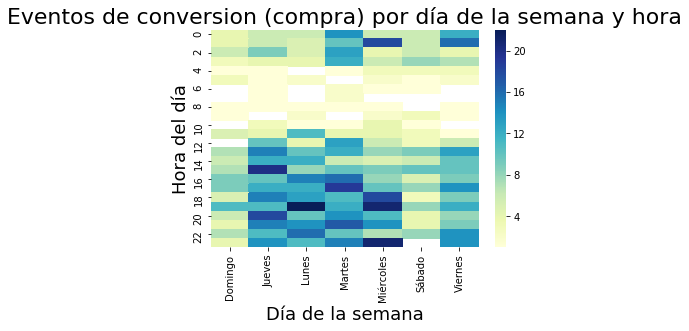

In [135]:
g = sns.heatmap(table,  cmap="YlGnBu")
g.set_title("Eventos de conversion (compra) por día de la semana y hora", fontsize=22)
g.set_xlabel("Día de la semana",fontsize=18)
g.set_ylabel("Hora del día", fontsize=18)

Esta informacion se corresponde con la obtenida anteriormente para los eventos en general. Mostrando nuevamente que dentro de las horas de la mañana 3-11 hay casi nada de actividad y los días de fin de semana hay menos actividad.

In [136]:
del(table)
del(g)

## Conversiones segun el modelo

In [60]:
# Vemos como se distribuyen los NaN
print("Cantidad de nans para eventos de compra: " + str(eventos_conversion.model.size - eventos_conversion.model.count()))

Cantidad de nans para eventos de compra: 0


No hay ningun NaN en los eventos de conversion para el modelo. Esto tiene sentido dado que el evento de conversion se genera al comprar un producto determinado, por lo cual se tiene que generar la informacion correspondiente a dicho dispositivo. 

Veamos los 10 modelos más comúnes en el evento conversion. Hay demasiados modelos como para enfocarnos en ver todos los modelos y las distribuciones de cantidad de veces que aparecen en el evento.

In [79]:
conversion_per_model = eventos_conversion.model.str.lower().value_counts().head(10)
conversion_per_model

samsung galaxy j5         88
iphone 5s                 84
iphone 6                  71
samsung galaxy s6 flat    39
iphone 6s                 37
iphone 5c                 33
motorola moto g3 4g       30
motorola moto g4 plus     30
samsung galaxy j7         28
samsung galaxy a5         27
Name: model, dtype: int64

In [81]:
eventos_conversion.model.str.lower().value_counts(normalize = True).head(10)

samsung galaxy j5         0.075085
iphone 5s                 0.071672
iphone 6                  0.060580
samsung galaxy s6 flat    0.033276
iphone 6s                 0.031570
iphone 5c                 0.028157
motorola moto g3 4g       0.025597
motorola moto g4 plus     0.025597
samsung galaxy j7         0.023891
samsung galaxy a5         0.023038
Name: model, dtype: float64

Text(0,0.5,'Modelo')

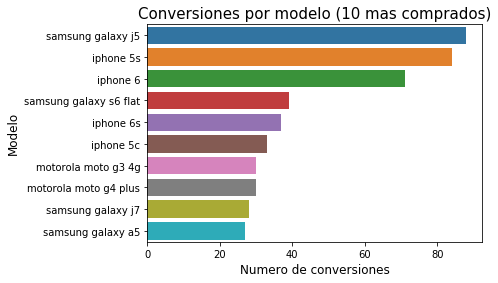

In [83]:
g = sns.barplot(x=conversion_per_model.values, y=conversion_per_model.index, orient='h')
g.set_title("Conversiones por modelo (10 mas comprados)", fontsize=15) # o mas vendidos?
g.set_xlabel("Numero de conversiones", fontsize=12)
g.set_ylabel("Modelo", fontsize=12) #o modelos??

Se ve claramente como los primeros 3 modelos tienen un valor de conversiones considerablemente mayor al resto de los modelos. El Samsung Galaxy J5 representa mas de doble de los ultimos 7 modelos. 

In [85]:
del(conversion_per_model)
del(g)

# Analisis por caracteristicas de celulares

## Storage

In [89]:
eventos_check_out  = data.loc[data.event == 'checkout']
eventos_check_out.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,operating_system_version,browser_version,anio,mes,mes_nombre,dia,hora,date,dia del anio,dia_semana
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,2018,5,May,31,23,2018-05-31,151,Jueves
7,2018-05-29 13:29:35,checkout,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,2018,5,May,29,13,2018-05-29,149,Martes
44,2018-05-24 11:34:32,checkout,000a54b2,NaN,12660.0,Motorola Moto Z Play,Bom,32GB,Preto,NaN,...,NaN,NaN,2018,5,May,24,11,2018-05-24,144,Jueves
85,2018-04-06 05:14:58,checkout,00184bf9,NaN,6355.0,Samsung Galaxy J5,Excelente,16GB,Preto,NaN,...,NaN,NaN,2018,4,Apr,6,5,2018-04-06,96,Viernes
86,2018-04-06 05:18:15,checkout,00184bf9,NaN,6355.0,Samsung Galaxy J5,Excelente,16GB,Preto,NaN,...,NaN,NaN,2018,4,Apr,6,5,2018-04-06,96,Viernes


In [90]:
check_out_per_storage = eventos_check_out.storage.value_counts()
check_out_per_storage

16GB     12462
32GB      9729
64GB      5436
8GB       3638
128GB     1840
4GB        295
256GB      270
512MB       63
Name: storage, dtype: int64

In [45]:
mes = {1:"Jan",2: "Feb",3: "Mar",4: "May",5: "Jun"}

# guardo meses en el orden deseado
sorter = ["Jan", "Feb","Mar", "Apr", "May", "Jun"]
sorterIndex = dict(zip(sorter,range(len(sorter))))

# creo df con cantidad de eventos agrupados por dia de la semana
#dfEventosAgrupado = df[['event','dia_semana']].groupby("dia_semana").count()
#dfEventosAgrupado["day"] = dfEventosAgrupado.index

# ordenamiento coherente para evitar el default (alfabetico)
#dfEventosAgrupado["day"] = dfEventosAgrupado["day"].map(sorterIndex)

#grafico = dfEventosAgrupado.sort_values("day").plot(kind = "barh")
#grafico.legend_.remove()
#grafico.set_title("Cantidad de eventos por día de la semana", fontsize=18)
#grafico.set_xlabel("Día de la semana", fontsize=12)
#grafico.set_ylabel("Cantidad de eventos", fontsize=12)

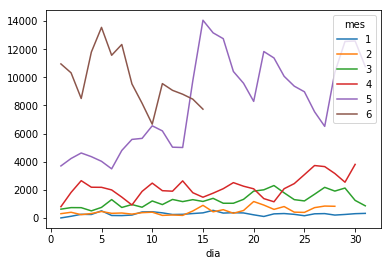

In [31]:
viewed_product_distribucion = data[ data['event'] == 'viewed product'].groupby(['dia', 'mes'])['mes_nombre']
vpd = viewed_product_distribucion.agg('count').unstack()
vpd.plot()

In [67]:
vp = data[ data['event'] == 'viewed product']

In [68]:
for_heatmap = vp.pivot_table(index='mes', columns='dia', values='timestamp', aggfunc='count')
for_heatmap

dia,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
mes,,,,,,,,,,,,,,,,,,,,,
1,6.0,122.0,263.0,250.0,510.0,179.0,171.0,210.0,431.0,445.0,...,294.0,317.0,260.0,161.0,298.0,313.0,208.0,252.0,307.0,329.0
2,307.0,407.0,238.0,319.0,464.0,333.0,355.0,277.0,379.0,413.0,...,613.0,814.0,416.0,399.0,737.0,849.0,833.0,NaN,NaN,NaN
3,629.0,739.0,735.0,507.0,755.0,1309.0,749.0,956.0,767.0,1211.0,...,2309.0,1790.0,1306.0,1214.0,1690.0,2180.0,1914.0,2130.0,1252.0,866.0
4,805.0,1818.0,2654.0,2188.0,2182.0,1997.0,1486.0,925.0,1892.0,2481.0,...,1154.0,2081.0,2446.0,3084.0,3731.0,3655.0,3164.0,2545.0,3812.0,NaN
5,3702.0,4231.0,4623.0,4362.0,4031.0,3496.0,4802.0,5589.0,5662.0,6556.0,...,11380.0,10077.0,9375.0,8976.0,7555.0,6516.0,10359.0,12552.0,12587.0,10767.0
6,10956.0,10323.0,8499.0,11799.0,13555.0,11571.0,12339.0,9533.0,8158.0,6670.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(141,0.5,'Mes del evento')

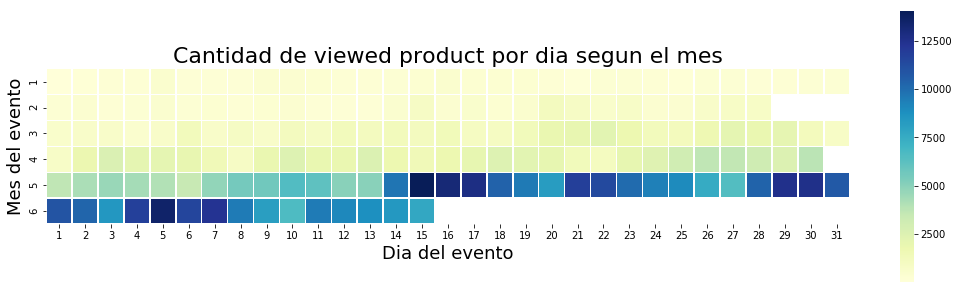

In [71]:
plt.figure(figsize=(18, 5))
g = sns.heatmap(for_heatmap,  cmap="YlGnBu",square=True,  linewidths=.5)
g.set_title("Cantidad de viewed product por dia segun el mes", fontsize=22)
g.set_xlabel("Dia del evento",fontsize=18)
g.set_ylabel("Mes del evento", fontsize=18)

Es importante comparar los eventos checkout y conversion

[Unstacking]


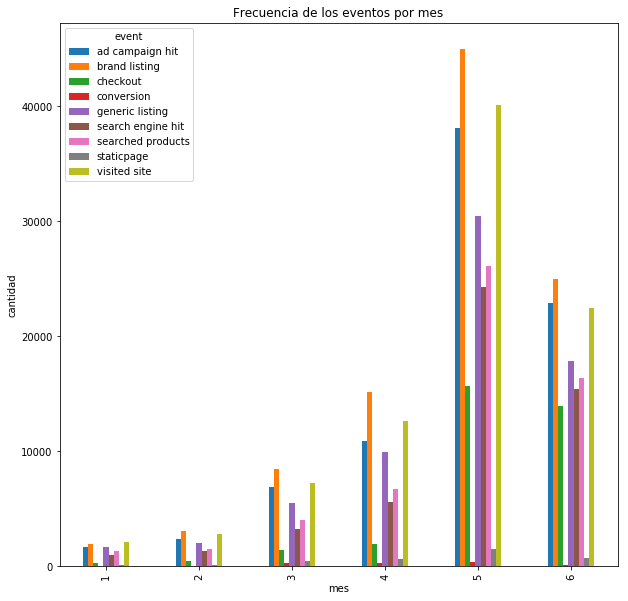

In [28]:
#Primero filtro los eventos que me interesan
e = data[ (data['event'] != 'viewed product') & (data['event'] != 'lead')]
#Group By mes y evento
groupbymesyevento = e.groupby(['mes', 'event'])

#Without the hierarchical indexing
print ("[Unstacking]" )
regimentbucketclicksum = groupbymesyevento['person'].agg('count').unstack()

regimentbucketclicksum.plot(kind = 'bar', title = 'Frecuencia de los eventos por mes', figsize=(10,10))

plt.ylabel('cantidad')
plt.show()

In [16]:
p = data[ ['person', 'event']]
grouped = p.groupby('person')['event']


In [19]:
p = data[['person', 'event']]
p['ad campaign hit'] = p['event'].str.contains['ad campaign hit']
p

TypeError: 'method' object is not subscriptable

In [31]:
#data['event'] = data['event'].astype('category')

In [5]:
ap = pd.DataFrame()
ap = pd.crosstab(data['person'], data['event'])

In [6]:
ap.head()

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
person,,,,,,,,,,,
0004b0a2,1,0,1,0,0,0,0,0,0,1,1
0006a21a,1,0,1,0,0,0,0,0,0,1,1
000a54b2,2,6,1,0,5,0,2,0,0,19,2
00184bf9,0,7,4,0,0,0,2,0,0,36,2
0019c395,2,0,1,0,0,0,2,0,0,2,1


In [13]:
ap.describe()

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
count,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000,27624.000000
mean,2.998371,3.570627,1.221221,0.042427,2.444758,0.016218,1.844664,2.029865,0.130249,19.147517,3.163119
std,7.235963,16.253314,1.215497,0.345757,7.154502,0.210565,3.877810,8.323393,0.876540,51.142526,6.873227
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,5.000000,1.000000
75%,3.000000,2.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.000000,0.000000,16.000000,3.000000
max,279.000000,1149.000000,38.000000,15.000000,424.000000,16.000000,139.000000,426.000000,32.000000,1525.000000,263.000000


In [17]:
print( 'promedio: ', ap.mean() , ",desviacion estandar: " , ap.std())

promedio:  event
ad campaign hit       2.998371
brand listing         3.570627
checkout              1.221221
conversion            0.042427
generic listing       2.444758
lead                  0.016218
search engine hit     1.844664
searched products     2.029865
staticpage            0.130249
viewed product       19.147517
visited site          3.163119
dtype: float64 ,desviacion estandar:  event
ad campaign hit       7.235963
brand listing        16.253314
checkout              1.215497
conversion            0.345757
generic listing       7.154502
lead                  0.210565
search engine hit     3.877810
searched products     8.323393
staticpage            0.876540
viewed product       51.142526
visited site          6.873227
dtype: float64


In [18]:
ap.agg(['mean', 'std'])

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
mean,2.998371,3.570627,1.221221,0.042427,2.444758,0.016218,1.844664,2.029865,0.130249,19.147517,3.163119
std,7.235963,16.253314,1.215497,0.345757,7.154502,0.210565,3.877810,8.323393,0.876540,51.142526,6.873227


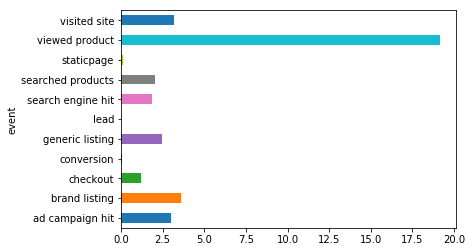

In [19]:
ap.mean().plot(kind='barh')

In [25]:
ap = ap.astype('bool')

In [26]:
from mlxtend.frequent_patterns import apriori
apriori_result = apriori(ap, min_support=0.0, use_colnames=True, max_len=2)

In [27]:
apriori_result.head()

,support,itemsets
0,0.771503,(ad campaign hit)
1,0.391725,(brand listing)
2,1.000000,(checkout)
3,0.025919,(conversion)
4,0.557631,(generic listing)


In [28]:
support_per_category = apriori_result[apriori_result['itemsets'].apply(lambda x: len(x) == 1)]

support_per_category = support_per_category.rename(columns={'itemsets':'category'})

In [29]:
support_per_category['category'] = support_per_category.category.apply(lambda x: x[0])

TypeError: 'frozenset' object does not support indexing

In [30]:
support_per_category.head()

,support,category
0,0.771503,(ad campaign hit)
1,0.391725,(brand listing)
2,1.000000,(checkout)
3,0.025919,(conversion)
4,0.557631,(generic listing)


In [31]:
support_per_category = support_per_category.set_index('category').T

In [32]:
support_per_category.head()

category,(ad campaign hit),(brand listing),(checkout),(conversion),(generic listing),(lead),(search engine hit),(searched products),(staticpage),(viewed product),(visited site)
support,0.771503,0.391725,1.0,0.025919,0.557631,0.010534,0.622828,0.268607,0.053396,0.95265,0.973755


In [33]:
apriori_result = apriori_result[apriori_result['itemsets'].apply(lambda x: len(x) == 2)]

In [34]:
apriori_result.head()

,support,itemsets
11,0.314292,"(ad campaign hit, brand listing)"
12,0.771503,"(ad campaign hit, checkout)"
13,0.020236,"(conversion, ad campaign hit)"
14,0.416811,"(generic listing, ad campaign hit)"
15,0.009267,"(lead, ad campaign hit)"


In [35]:
apriori_result = apriori_result.sort_values('support',ascending=False)
apriori_result.head()

,support,itemsets
37,0.973755,"(visited site, checkout)"
36,0.952650,"(viewed product, checkout)"
65,0.946025,"(viewed product, visited site)"
12,0.771503,"(ad campaign hit, checkout)"
20,0.768969,"(visited site, ad campaign hit)"


In [40]:
apriori_result = apriori_result.reset_index(drop=True)
apriori_result.head()

,support,itemsets
0,0.973755,"(visited site, checkout)"
1,0.952650,"(viewed product, checkout)"
2,0.946025,"(viewed product, visited site)"
3,0.771503,"(ad campaign hit, checkout)"
4,0.768969,"(visited site, ad campaign hit)"


In [45]:
apriori_result[ apriori_result['itemsets'] == {'checkout', 'conversion'} ]

,support,itemsets
36,0.025919,"(conversion, checkout)"


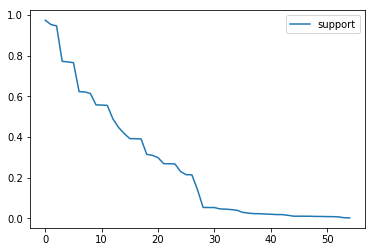

In [43]:
apriori_result.plot()

In [39]:
support_per_category.at['support','checkout'], support_per_category.at['support','conversion']

KeyError: 'checkout'

In [84]:
ap.plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [4]:
# Saco las columnas que no me interesan.
filtered = data.drop(['timestamp','person'], axis='columns')

In [53]:
def columnas_sin_nans_para_event(dataframe, event):
    return dataframe.loc[dataframe.event == event].iloc[0].dropna().index

In [54]:
for event in data.event.unique():
    print(event + ': ' + str(list(columnas_sin_nans_para_event(filtered, event).drop('event'))))

ad campaign hit: ['url', 'campaign_source']
visited site: ['channel', 'new_vs_returning', 'city', 'region', 'country', 'device_type', 'screen_resolution', 'operating_system_version', 'browser_version']
viewed product: ['sku', 'model', 'condition', 'storage', 'color']
checkout: ['sku', 'model', 'condition', 'storage', 'color']
generic listing: ['skus']
search engine hit: ['search_engine']
brand listing: ['skus']
searched products: ['skus', 'search_term']
conversion: ['sku', 'model', 'condition', 'storage', 'color']
staticpage: ['staticpage']
lead: ['model']


In [60]:
ind = data.columns.drop(['timestamp', 'person','event'])
ind

Index(['url', 'sku', 'model', 'condition', 'storage', 'color', 'skus',
       'search_term', 'staticpage', 'campaign_source', 'search_engine',
       'channel', 'new_vs_returning', 'city', 'region', 'country',
       'device_type', 'screen_resolution', 'operating_system_version',
       'browser_version'],
      dtype='object')

In [69]:
d = {'ad campaign hit' : pd.Series([1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0], index=ind),
     'visited site' : pd.Series([0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1], index= ind),
     'viewed product' : pd.Series([0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], index= ind),
     'checkout' : pd.Series([0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], index= ind),
     'generic listing' : pd.Series([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0], index= ind),
      'searched engine hit' : pd.Series([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0], index= ind),
      'brand listing' : pd.Series([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0], index= ind),
      'searched products' : pd.Series([0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0], index= ind),
      'conversion' : pd.Series([0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], index= ind),
      'staticpage' : pd.Series([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0], index= ind),
      'lead' : pd.Series([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], index= ind)}

In [70]:
df = pd.DataFrame(d)
df


,ad campaign hit,visited site,viewed product,checkout,generic listing,searched engine hit,brand listing,searched products,conversion,staticpage,lead
url,1,0,0,0,0,0,0,0,0,0,0
sku,0,0,1,1,0,0,0,0,1,0,0
model,0,0,1,1,0,0,0,0,1,0,1
condition,0,0,1,1,0,0,0,0,1,0,0
storage,0,0,1,1,0,0,0,0,1,0,0
color,0,0,1,1,0,0,0,0,1,0,0
skus,0,0,0,0,1,0,1,1,0,0,0
search_term,0,0,0,0,0,0,0,1,0,0,0
staticpage,0,0,0,0,0,0,0,0,0,1,0
campaign_source,1,0,0,0,0,0,0,0,0,0,0


Text(396.109,0.5,'Eventos')

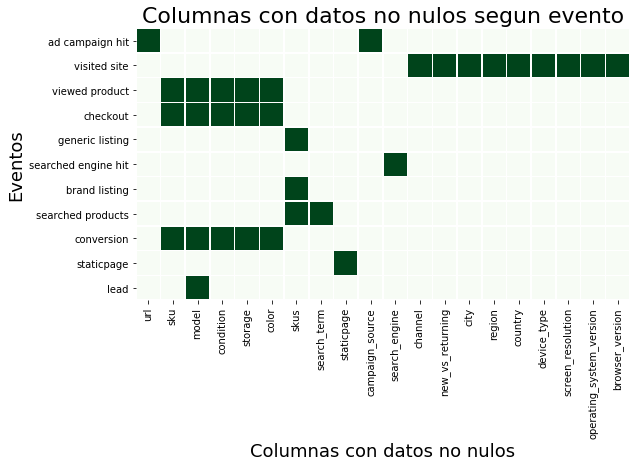

In [92]:
plt.figure(figsize=(18, 5))
g = sns.heatmap(df.T,linewidths=0.5, linecolor='white', square=True,cmap="Greens",cbar=False)
g.set_title("Columnas con datos no nulos segun evento", fontsize=22)
g.set_xlabel("Columnas con datos no nulos",fontsize=18)
g.set_ylabel("Eventos", fontsize=18)

In [51]:
usuarios_nuevos = data[ data['new_vs_returning'] == 'New']

In [48]:
data['new_vs_returning'].value_counts()

Returning    60480
New          26898
Name: new_vs_returning, dtype: int64

In [59]:
a = data[['person', 'timestamp','city','event','new_vs_returning']].dropna()
a

,person,timestamp,city,event,new_vs_returning
1,0004b0a2,2018-05-31 23:38:05,Camaragibe,visited site,New
5,0006a21a,2018-05-29 13:29:26,Rio de Janeiro,visited site,New
9,000a54b2,2018-04-09 20:12:31,Rio de Janeiro,visited site,New
16,000a54b2,2018-05-24 11:21:07,Rio de Janeiro,visited site,Returning
45,00184bf9,2018-04-06 05:12:05,Ribeirão Preto,visited site,New
87,00184bf9,2018-05-04 18:47:03,Ribeirão Preto,visited site,Returning
96,0019c395,2018-05-17 00:08:56,Unknown,visited site,New
106,001bb7eb,2018-06-06 18:40:53,Unknown,visited site,New
108,001bb7eb,2018-06-08 12:15:33,Unknown,visited site,Returning
112,001f1653,2018-05-29 12:56:08,Unknown,visited site,New
